In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import scienceplots 

# Binary Pulsar Line of Sight Radial Velocity, pp. X - X, Pulsar Handbook (2004)

Orbital Phase is given by, $\phi = \omega  + A_T$. Where $\omega$ is the longitude of peri-astron. 

Orbital velocity is given by, 

$$ V_{orb} = \dfrac{2 \pi x c}{\sin(i)\sqrt{(1-e^2)}P_b} $$

Where, $e$ is eccentricity, $i$ is orbital inclination, $P_b$ is orbital period and $x$ is projected semi-major axis of the orbit in light seconds. 

Radial velocity is given as, 

$$ V_r = V_{orb} e \sin A_T $$

In [ ]:
def v_orb(e, i, P_b, x): 
    '''
    e = eccentricity
    i = inclination
    P_b = orbital period
    x = projected semi-major axis in light-seconds
    '''
    c = 2.99792458e8 # m/s
    numerator = 2.0 * np.pi * x * c 
    denominator = np.sin(i)*np.sqrt(1 - e**2)*P_b

    return numerator/denominator

def v_rad(v_orb, e, omega, phase):
    '''
    v_orb = orbital velocity
    e = eccentricity
    omega = argument of periastron
    phase = orbital phase
    '''
    return v_orb*(np.cos(omega + phase) + e*np.cos(omega))

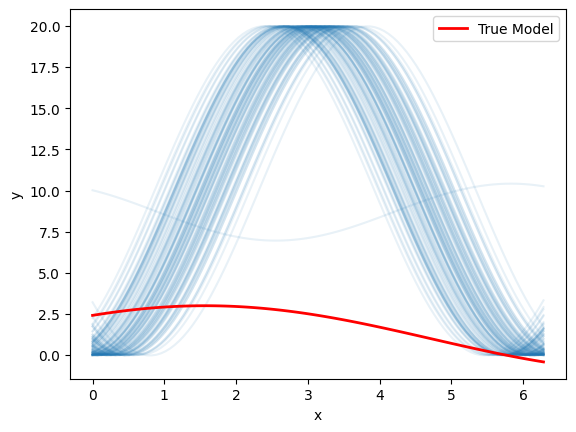

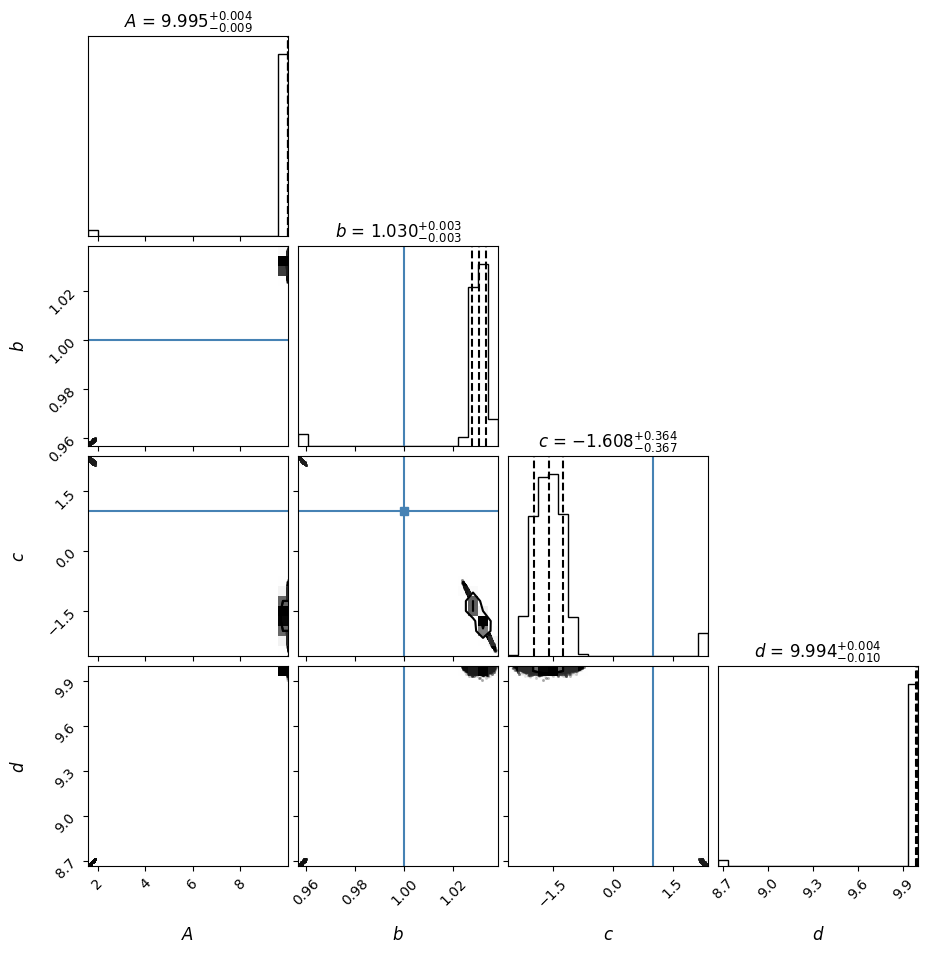

In [11]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
import corner

def model(x, A, b, c, d):
    return A * np.sin(x * b + c) + d

# Load true data from a text file
true_data = np.loadtxt('input/J0523-Strader-Fig3-extractd.txt', unpack=True, skiprows=1, usecols=(0,1), delimiter=',')
true_x = true_data[:, 0]
true_y = true_data[:, 1]

# Generate synthetic noisy data
np.random.seed(42)
y_noise = np.abs(0.1 * np.random.randn(len(true_x)))
y_data = true_y + y_noise

def ln_likelihood(params, x, y):
    A, b, c, d = params
    y_model = model(x, A, b, c, d)
    chi_squared = np.sum((y - y_model) ** 2)
    return -0.5 * chi_squared

def ln_prior(params):
    A, b, c, d = params
    
    # Uniform priors
    if 0 < A < 10 and 0 < b < 10 and -np.pi < c < np.pi and -10 < d < 10:
        return 0.0
    return -np.inf

def ln_posterior(params, x, y):
    prior = ln_prior(params)
    if np.isinf(prior):
        return prior
    likelihood = ln_likelihood(params, x, y)
    return prior + likelihood

nwalkers = 32  # Number of walkers
ndim = 4       # Number of parameters

true_A = 1; true_b = 1; true_c = 1; true_d = 1

# Initialize walkers with a small random perturbation around the true values
initial_params = [true_A, true_b, true_c, true_d]
initial_params = np.array(initial_params) + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(true_x, true_y))

# Burn-in phase
burn_in_steps = 1000
pos, _, _ = sampler.run_mcmc(initial_params, burn_in_steps)
sampler.reset()

# Production phase
n_steps = 5000
sampler.run_mcmc(pos, n_steps)

# Flatten the chain
samples = sampler.get_chain(flat=True)

# Plot some example fits from the posterior
plt.figure()
for params in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(x, model(x, *params), color="C0", alpha=0.1)
# plt.errorbar(x, y_data, yerr=y_noise, fmt=".k", label="Data")
plt.plot(x, y_true, color="r", lw=2, label="True Model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# Reshape the samples into a 2D array with shape (n_samples, n_parameters)
samples_reshaped = samples.reshape(-1, ndim)

# Define labels for the parameters
param_labels = [r"$A$", r"$b$", r"$c$", r"$d$"]

# Create the corner plot
corner_fig = corner.corner(
    samples_reshaped,
    labels=param_labels,
    quantiles=[0.16, 0.5, 0.84],  # Add credible interval lines
    show_titles=True,  # Display parameter names on the diagonal
    title_fmt=".3f",  # Format for parameter value display
    title_kwargs={"fontsize": 12},  # Adjust title font size
    label_kwargs={"fontsize": 12},  # Adjust label font size
    truths=[true_A, true_b, true_c, true_d],  # Optionally add true parameter values
)

# Show the corner plot
plt.show()
